### Overview

I've spent the past fifteen or so years collecting, trading, and obsessing over music equipment. This means that I've spent a good amount of time online looking at what I can add to my collection. One of the largest online marketplaces for music equipment is Reverb. Reverb allows users to make posts at no cost as well as offers a platform for price tracking, negotiation, and general music equipment exploration.

Having been on both sides of the Reverb marketplace, I've found that selling equipment is significantly harder due to the competition you face with other sellers. I've often wondered in the past if there are any important features to highlight or settings to enable that would give my posts an advantage in a sea of similar equipment.

The goal for this project is to develop a predictive model to classify whether a product is likely to sell based on the post information and product details. To start, I'm importing the libraries we'll need and importing a list of links to a couple thousand posts.

Before jumping into the code, I'll quickly explain my data collection strategy for this project. Ensuring that the products in this dataset are as similar as possible is crucial. The features that are important for a keyboard may be totally irrelevant for a drum set. For this reason, I did some research on the most popular products currently on Reverb and found that the "Fender American Professional II Stratocaster" was one of the most popular. The website has about 1,000 current listings up, and about 1,300 sold listings archived for this product. Now we can get into the code!

In [1151]:
import numpy as np
import pandas as pd
import requests
import json
import re
import pickle

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import GridSearchCV

from xgboost import XGBClassifier

### Data Collection

Using the Chrome WebScraper extension, I iterated through each page of the search results to collect a list of links. Here, I am parsing each of those lists into a dataframe.

In [315]:
scraped_links = pd.read_csv('/Users/brianmcniff/Downloads/reverb_strat.csv')
scraped_links['post_id'] = [link.split('/')[4].split('-')[0] for link in scraped_links['links-href']]
scraped_links['post_id_int'] = [int(post_id) for post_id in scraped_links['post_id']]

scraped_links_sold = pd.read_csv('/Users/brianmcniff/Downloads/reverb_strat_sold.csv')
scraped_links_sold['post_id'] = [link.split('/')[4].split('-')[0] for link in scraped_links_sold['links-href']]
scraped_links_sold['post_id_int'] = [int(post_id) for post_id in scraped_links_sold['post_id']]

By referencing Reverb's API, I created a function to pull all info for a given post. I've included the first chunk of the response below, but this is quite long so we'll explore all relevant info later on.

In [1238]:
def get_post_info(id):
    headers = {
        'Content-Type': 'application/hal+json',
        'Accept': 'application/hal+json',
        'Accept-Version': '3.0',
        'Authorization': 'Bearer secret_key'
    }

    response = requests.get(f'https://api.reverb.com/api/listings/{id}', headers=headers)
    return response.text

test_row = get_post_info(73348569)
test_row[:500]

'{"id":73348569,"make":"Fender","model":"Miami Blue American Professional II Stratocaster","finish":"Miami Blue","year":"2021","title":"Miami Blue Fender American Professional II Stratocaster","created_at":"2023-09-11T10:15:00-05:00","shop_name":"Kev’s Killer Guitars","shop":{"feedback_count":31,"preferred_seller":false,"rating_percentage":1.0},"description":"<p>You won’t find a nicer Rosewood fretboard on a new Strat! The grain and color are gorgeous. One owner! This is a 2021 (75th Anniversary)'

Iterating through each of our links, we can pull in all data for each product that matches our requirements. It's worth noting that although we are not hitting Reverb with a massive number of requests, it's still worth saving this to disk to avoid making additional requests for the same posts in the future.

In [314]:
all_post_info = {}

for post in scraped_links['post_id']:
    all_post_info[post] = get_post_info(post)

all_sold_post_info = {}

for post in scraped_links_sold['post_id']:
    all_sold_post_info[post] = get_post_info(post)
    
# save/load dict from disk to avoid duplicating API calls
with open('reverb_all_post_info.pkl', 'wb') as f:
    pickle.dump(all_post_info, f)
        
# with open('reverb_all_post_info.pkl', 'rb') as f:
#     all_post_info_from_disk = pickle.load(f)

with open('reverb_all_sold_post_info.pkl', 'wb') as f:
    pickle.dump(all_sold_post_info, f)
        
# with open('reverb_all_post_info.pkl', 'rb') as f:
#     all_post_info_from_disk = pickle.load(f)

### Data Processing

The next step is to parse this JSON into a dataframe. Luckily, the json_normalize function does exactly what I need right out of the box. We again iterate through each post in our JSON response, and add a row for each post to a dataframe.

In [1157]:
def json_to_df(json_response, post_id):
    posting = {}
    for field, value in json.loads(json_response[post_id]).items():
        posting[field] = value

    posting_df = pd.json_normalize(posting)

    return posting_df

In [1158]:
# create empty post dataframe using keys from JSON response
for field, value in json.loads(test_row).items():
    posting[field] = value

posting_df = pd.json_normalize(posting)
posting_df = df.drop(index = 0)

for post_id in all_post_info:
    df_row = json_to_df(all_post_info, post_id)
    posting_df = pd.concat([posting_df, df_row], ignore_index=True)
    
# create empty sold post dataframe using keys from JSON response
for field, value in json.loads(test_row).items():
    posting[field] = value

sold_posting_df = pd.json_normalize(posting)
sold_posting_df = df.drop(index = 0)

for post_id in all_sold_post_info:
    df_row = json_to_df(all_sold_post_info, post_id)
    sold_posting_df = pd.concat([sold_posting_df, df_row], ignore_index=True)

One important note to make is that current posts (products still for sale) that were recently added are not good indicators of unsold products since they may still sell given enough time. For this reason, I decided to remove all open posts from the past three months, just to increase the confidence that our unsold products are far less likely to convert to sold products.

We're also merging our sold and non-sold dataframes into one here, with the inclusion of an "is_sold" field (which will become our dependent variable).

In [1159]:
# remove recently added but not yet sold guitars (may convert to sold guitars given enough time)
posting_df = posting_df[pd.to_datetime(posting_df['created_at']) < pd.to_datetime('2023-07-01 00:00:00-04:00')].copy()

posting_df['is_sold'] = 0
sold_posting_df['is_sold'] = 1

all_posting_df = pd.concat([posting_df, sold_posting_df],join='inner', ignore_index=True)

### Feature Engineering

After exploring the data, there are a handful of ideas I have for additional features. It's likely that many of these will go unused, but absolutely worth experimenting with to see. The purpose of each feature is explained with inline comments.

In [1160]:
# character length of title and description
all_posting_df['len_title'] = [len(post) for post in all_posting_df['title']]
all_posting_df['len_description'] = [len(post) for post in all_posting_df['description']]

# number of photos and videos in post
all_posting_df['num_photos'] = [len(post) for post in all_posting_df['cloudinary_photos']]
all_posting_df['num_videos'] = [len(post) for post in all_posting_df['videos']]

# boolean for each payment type accepted
all_posting_df['direct_checkout_accepted'] = ['direct_checkout' in accepted_list for accepted_list in all_posting_df['accepted_payment_methods']]
all_posting_df['paypal_accepted'] = ['paypal' in accepted_list for accepted_list in all_posting_df['accepted_payment_methods']]
all_posting_df['affirm_accepted'] = ['affirm' in accepted_list for accepted_list in all_posting_df['accepted_payment_methods']]
all_posting_df['klarna_accepted'] = ['klarna_account' in accepted_list for accepted_list in all_posting_df['accepted_payment_methods']]

# truncating year for cleaner grouping
all_posting_df['year_trunc'] = [str(year)[:4].lower() for year in all_posting_df['year']]

# title mentions including a case
all_posting_df['includes_case'] = ['case' in title.lower() for title in all_posting_df['title']]

# percent difference between current price and original price
all_posting_df['price_drop_percent'] = 1.0 - (all_posting_df['price.amount'].astype(float) / all_posting_df['original_price.amount'].astype(float))

# formatting finishes for cleaner grouping
finish_list = []

for post in all_posting_df['finish']:
    if   'burst' in post.lower():
        finish_list.append('Sunburst')
    elif 'dark' in post.lower():
        finish_list.append('Dark Night')
    elif 'black' in post.lower():
        finish_list.append('Black')
    elif 'blue' in post.lower():
        finish_list.append('Miami Blue')
    elif 'miami' in post.lower():
        finish_list.append('Miami Blue')
    elif 'green' in post.lower():
        finish_list.append('Mystic Surf Green')
    elif 'white' in post.lower():
        finish_list.append('Olympic White')
    elif 'pine' in post.lower():
        finish_list.append('Roasted Pine')
    else:
        finish_list.append('Other')
        
all_posting_df['finish_formatted'] = finish_list

# extracting number of days from return policy
days_to_return = [re.findall(r'\d+', post) for post in all_posting_df['return_policy.description']]
all_posting_df['days_to_return_int'] = [int(post[0]) if len(post) > 0 else 0 for post in days_to_return]

# checking whether coupon code is available
all_posting_df['has_coupon_code'] = pd.isna(all_posting_df['coupon.code'])

It's also good to take some time to remove any columns that are just going to create noise or contribute very little. I've done this systematically by removing features with unique values on each row, and removing features that only have one unique value. I then went through each feature in the datasource and manually excluded any redundant fields (for example, "price", "price_in_cents", "price_label", etc.)

In [1161]:
#removing id columns
id_columns = all_posting_df.columns[all_posting_df.astype('string').nunique(dropna=False) == 1015]
all_posting_df = all_posting_df.drop(columns=id_columns)

# removing columns with only a single unique value
columns_w_one_value = all_posting_df.columns[all_posting_df.astype('string').nunique(dropna=False) <= 1]
all_posting_df = all_posting_df.drop(columns=columns_w_one_value)

In [1162]:
feature_cols = ['inventory',
        'has_inventory',
        'offers_enabled',
        'listing_currency',
        'handmade',
        'local_pickup_only',
        'sold_as_is',
        'upc_does_not_apply',
        'origin_country_code',
        'same_day_shipping_ineligible',
        'shop.feedback_count',
        'shop.preferred_seller',
        'shop.rating_percentage',
        'condition.display_name',
        'price.amount',
        'shipping.free_expedited_shipping',
        'shipping.local',
        'shipping.user_region_rate.region_code',
        'shipping.user_region_rate.rate.amount',
        'shipping.user_region_rate.regional',
        'shipping.user_region_rate.destination_postal_code_needed',
        'location.country_code',
        'original_price.amount',
        'price_drop_percent',
        'len_title',
        'len_description',
        'num_photos',
        'direct_checkout_accepted',
        'paypal_accepted',
        'affirm_accepted',
        'klarna_accepted',
        'year_trunc',
        'includes_case',
        'finish_formatted',
        'days_to_return_int',
        'has_coupon_code']

X = all_posting_df[feature_cols]
y = all_posting_df['is_sold']

Fortunately all of the fields that require missing value imputation have a reasonable value to impute. For example, if 'original_price' is missing, we can assume there is no original price, since the product's price hasn't changed. Another example is for "handmade". It's safe to assume that a handmade guitar would use this as its main selling point, so I don't expect to see many handmade guitars with that field missing.

In [1163]:
# impute missing values
X['handmade'] = X['handmade'].fillna(False)
X['upc_does_not_apply'] = X['upc_does_not_apply'].fillna(False)
X['shipping.user_region_rate.regional'] = X['shipping.user_region_rate.regional'].fillna(False)
X['shipping.user_region_rate.destination_postal_code_needed'] = X['shipping.user_region_rate.destination_postal_code_needed'].fillna(False)

X['original_price.amount'] = X['original_price.amount'].fillna(X['price.amount'])

X['price_drop_percent'] = X['price_drop_percent'].fillna(0)
X['shipping.user_region_rate.rate.amount'] = X['shipping.user_region_rate.rate.amount'].fillna(0)

X['shipping.user_region_rate.region_code'] = X['shipping.user_region_rate.region_code'].fillna('missing')
X['origin_country_code'] = X['origin_country_code'].fillna('missing')

/var/folders/hc/411myfb10_18fz7bnd_tnmqh0000gn/T/ipykernel_14980/2228620318.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['handmade'] = X['handmade'].fillna(False)
/var/folders/hc/411myfb10_18fz7bnd_tnmqh0000gn/T/ipykernel_14980/2228620318.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['upc_does_not_apply'] = X['upc_does_not_apply'].fillna(False)
/var/folders/hc/411myfb10_18fz7bnd_tnmqh0000gn/T/ipykernel_14980/2228620318.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

Preparing for one-hot encoding, I separated out all of the categorical columns and ran each through a function that encodes and removes the original field from our dataframe. The resulting columns are displayed below.

In [1164]:
categorical_columns = [
    'has_inventory', 
    'offers_enabled', 
    'listing_currency',
    'handmade', 
    'local_pickup_only', 
    'sold_as_is', 
    'upc_does_not_apply',
    'origin_country_code', 
    'same_day_shipping_ineligible',
    'shop.preferred_seller',
    'condition.display_name',
    'shipping.free_expedited_shipping',
    'shipping.local', 
    'shipping.user_region_rate.region_code',
    'shipping.user_region_rate.regional',
    'shipping.user_region_rate.destination_postal_code_needed',
    'location.country_code', 
    'direct_checkout_accepted', 
    'paypal_accepted', 
    'affirm_accepted',
    'klarna_accepted', 
    'year_trunc', 
    'includes_case', 
    'finish_formatted', 
    'has_coupon_code'
]

In [1165]:
def one_hot_encode(df, col_name):
    one_hot_df = pd.get_dummies(data=df[col_name], prefix=col_name, prefix_sep='_', drop_first=True)
    df = df.drop(columns=[col_name])
    df = pd.merge(left=df, right=one_hot_df, left_index=True, right_index=True, how='inner')
    return df

for col in categorical_columns:
    X = one_hot_encode(X, col)

In [1166]:
X.columns

Index(['inventory', 'shop.feedback_count', 'shop.rating_percentage',
       'price.amount', 'shipping.user_region_rate.rate.amount',
       'original_price.amount', 'price_drop_percent', 'len_title',
       'len_description', 'num_photos', 'days_to_return_int',
       'has_inventory_True', 'offers_enabled_True', 'listing_currency_CAD',
       'listing_currency_EUR', 'listing_currency_GBP', 'listing_currency_JPY',
       'listing_currency_USD', 'handmade_True', 'local_pickup_only_True',
       'sold_as_is_True', 'upc_does_not_apply_True',
       'origin_country_code_missing', 'same_day_shipping_ineligible_True',
       'shop.preferred_seller_True', 'condition.display_name_Brand New',
       'condition.display_name_Excellent', 'condition.display_name_Good',
       'condition.display_name_Mint', 'condition.display_name_Very Good',
       'shipping.free_expedited_shipping_True', 'shipping.local_True',
       'shipping.user_region_rate.region_code_US',
       'shipping.user_region_rate.regi

Lastly, we'll need to partition our data into train and test groups. Since I'm going to be experimenting with this a good amount, I'm going to use a training and validation set, and employ a third test set as a final check at the end of the project. This helps to further ensure that our model is not overfitting to data it's familiar with.

In [1167]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=100)

### Making Predictions
My plan for this part of the process is to start with a baseline logistic regression model to see how it performs. Ideally, we can use this model to reduce our features to the most important ones as well. We'll be using F1 score and a confusion matrix to interpret our model's performance across each change.

In [1168]:
logreg = LogisticRegression(max_iter=10000, random_state=100)
logreg.fit(X_train.astype(float), y_train)
y_pred_train = logreg.predict(X_train.astype(float))
y_pred_val = logreg.predict(X_val.astype(float))

print('Training F1 Score:\t{}'.format(f1_score(y_train, y_pred_train)))
print('Validation F1 Score: \t{}'.format(f1_score(y_val, y_pred_val)))
print(confusion_matrix(y_val, y_pred_val))

Training F1 Score:	0.9986824769433464
Validation F1 Score: 	0.9980119284294234
[[158   1]
 [  0 251]]


Wow! This is a great F1 score! ...suspiciously great. My assumption is that one of our fields is contributing to data leakage and causing our model to perform unrealistically well. In order to determine which field may be causing this, let's first employ some feature selection to narrow down which fields are doing the heavy lifting. 

I also want to acknowledge that I'm setting the max_iter parameter in our model fairly high because the model is throwing a warning that it doesn't have enough iterations to converge. If this were a larger more resource intensive dataset/model, a more performant approach would be to scale our data for convergence in less iterations, but this is taking less than a minute either way, so this solution will work for now.

In [1169]:
logreg_sfs = LogisticRegression(max_iter = 10000, random_state=100)
sfs = SequentialFeatureSelector(logreg_sfs, n_features_to_select=10)
sfs.fit(X, y)
included_features = sfs.get_support()
X.iloc[:,included_features]
included_features_init = included_features

,inventory,shop.rating_percentage,price.amount,shipping.user_region_rate.rate.amount,original_price.amount,price_drop_percent,len_title,num_photos,days_to_return_int,offers_enabled_True
0,1,0.996569,1529.99,0.00,1529.99,0.000000,68,11,30,0
1,1,0.991469,1699.99,0.00,1699.99,0.000000,90,9,30,1
2,1,0.991322,1259.99,0.00,1339.99,0.059702,80,5,30,1
3,0,0.991322,1259.99,0.00,1339.99,0.059702,74,5,30,1
4,4,0.991322,1259.99,0.00,1259.99,0.000000,77,5,30,1
...,...,...,...,...,...,...,...,...,...,...
2046,0,1.000000,1350.00,100.00,1600.00,0.156250,82,5,7,0
2047,0,0.988374,1699.99,0.00,1699.99,0.000000,88,10,14,0
2048,0,0.982306,1199.99,90.00,1399.99,0.142858,62,14,0,1
2049,0,0.997531,1199.00,36.00,1264.00,0.051424,86,8,1,0


Immediately after seeing this, I realized that inventory is likely our culprit. It stands to reason that a seller often has only one of these specific guitars in inventory, and if it's sold, the seller's inventory will be 0. Of course, we won't have this information when we create a post, so it cannot be included in our features. Removing it, we can see below a much more realistic model. 

Since we've limited the amount of features, it's great to see that our training and validation scores are so close, this means we're not dealing with a model that's overfitting to our training data.

In [1242]:
included_features_no_leak = included_features
included_features_no_leak[0] = False

logreg3 = LogisticRegression(max_iter=10000, random_state=100)
logreg3.fit(X_train.iloc[:,included_features_no_leak], y_train)
y_pred_train = logreg3.predict(X_train.iloc[:,included_features_no_leak])
y_pred_val = logreg3.predict(X_val.iloc[:,included_features_no_leak])

print('Training F1 Score:\t{}'.format(f1_score(y_train, y_pred_train)))
print('Validation F1 Score: \t{}'.format(f1_score(y_val, y_pred_val)))
print(confusion_matrix(y_val, y_pred_val))

Training F1 Score:	0.8019257221458047
Validation F1 Score: 	0.8041237113402062
[[120  39]
 [ 56 195]]


I was also curious to see if there were any other features that may be worth including. I was surprised to see such a strong negative correlation with the "Brand New" condition, but think this definitely justifies its inclusion as a feature.

In [1170]:
full_df = pd.merge(y, X, left_index=True, right_index=True)
full_df.corr().sort_values(by='is_sold', ascending=False).iloc[:,0]

is_sold                             1.000000
condition.display_name_Mint         0.325487
condition.display_name_Excellent    0.261010
upc_does_not_apply_True             0.250281
klarna_accepted_True                0.193083
                                      ...   
shop.preferred_seller_True         -0.249956
has_inventory_True                 -0.372589
days_to_return_int                 -0.384622
inventory                          -0.402008
condition.display_name_Brand New   -0.542157
Name: is_sold, Length: 68, dtype: float64

In [1241]:
included_features_no_leak[25] = True

logreg2 = LogisticRegression(max_iter=10000, random_state=100)
logreg2.fit(X_train.iloc[:,included_features_no_leak], y_train)
y_pred_train = logreg2.predict(X_train.iloc[:,included_features_no_leak])
y_pred_val = logreg2.predict(X_val.iloc[:,included_features_no_leak])

print('Training F1 Score:\t{}'.format(f1_score(y_train, y_pred_train)))
print('Validation F1 Score: \t{}'.format(f1_score(y_val, y_pred_val)))
print(confusion_matrix(y_val, y_pred_val))

Training F1 Score:	0.8019257221458047
Validation F1 Score: 	0.8041237113402062
[[120  39]
 [ 56 195]]


Next, I'm curious to see how some more powerful models would perform on this dataset. These functions are chained together to instantiate, fit, and score a few different models automatically. In this case, we are trying our baseline logistic regression model, a random forest classifier, and an XGBoost classifier. See the table below for results.

In [1186]:
def instantiate_and_fit(model_type, X_train, y_train, X_val, y_val):
    model = model_type
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    return (y_pred_train, y_pred_val)

def train_and_score(X_train, y_train, X_val, y_val):
    rmse_results = pd.DataFrame(columns = ['model', 'train', 'val', 'val_conf_matrix'])
    
    # Logistic Regression
    y_pred_train, y_pred_val = instantiate_and_fit(LogisticRegression(max_iter=10000, random_state=100), 
                                                   X_train.iloc[:,included_features_no_leak], 
                                                   y_train, 
                                                   X_val.iloc[:,included_features_no_leak], 
                                                   y_val)
    rmse_results.loc[len(rmse_results)] = ['logistic regression', 
                                           f1_score(y_train, y_pred_train), 
                                           f1_score(y_val, y_pred_val),
                                           confusion_matrix(y_val, y_pred_val)]
    
    # Random Forest Classifier
    y_pred_train, y_pred_val = instantiate_and_fit(RandomForestClassifier(random_state=100), 
                                                   X_train.iloc[:,included_features_no_leak], 
                                                   y_train, 
                                                   X_val.iloc[:,included_features_no_leak], 
                                                   y_val)
    rmse_results.loc[len(rmse_results)] = ['random forest', 
                                           f1_score(y_train, y_pred_train), 
                                           f1_score(y_val, y_pred_val),
                                           confusion_matrix(y_val, y_pred_val)]
    
    # XGBoost Classifier
    y_pred_train, y_pred_val = instantiate_and_fit(XGBClassifier(random_state=100), 
                                                   X_train.iloc[:,included_features_no_leak].astype(float), 
                                                   y_train, 
                                                   X_val.iloc[:,included_features_no_leak].astype(float), 
                                                   y_val)
    rmse_results.loc[len(rmse_results)] = ['xgboost', 
                                           f1_score(y_train, y_pred_train), 
                                           f1_score(y_val, y_pred_val),
                                           confusion_matrix(y_val, y_pred_val)]
    
    return rmse_results

train_and_score(X_train, y_train, X_val, y_val)

,model,train,val,val_conf_matrix
0,logistic regression,0.801926,0.804124,"[[120, 39], [56, 195]]"
1,random forest,0.999341,0.928287,"[[141, 18], [18, 233]]"
2,xgboost,0.999340,0.930140,"[[142, 17], [18, 233]]"


Again we see some good news that random forest and xgboost classifiers perform even better than our logistic regression model. In this case, I'm going to stick with XGBoost and next ensure that our hyperparameters are as optimal as possible.

### Hyperparameter Tuning
We're going to use sklearn's GridSearchCV function to try out a handful of hyperparameter combinations and see what performs best.

In [1187]:
xgb = XGBClassifier(random_state=100)

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = 10,
    cv = 10,
    verbose=True)

grid_search.fit(X.iloc[:,included_features_no_leak].astype(float), y)
grid_search.best_params_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


{'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100}

Using our strongest hyperparameters, we'll run the model one last time, and also pull in our test data to see how our model performs on data it has not seen at all during this process.

In [1188]:
xgb2 = XGBClassifier(learning_rate=0.01, max_depth=7, n_estimators=60, random_state=100)
xgb2.fit(X_train.iloc[:,included_features_no_leak].astype(float), y_train)
y_pred_train = xgb2.predict(X_train.iloc[:,included_features_no_leak].astype(float))
y_pred_val = xgb2.predict(X_val.iloc[:,included_features_no_leak].astype(float))
y_pred_test = xgb2.predict(X_test.iloc[:,included_features_no_leak].astype(float))

print('Training F1 Score:\t{}'.format(f1_score(y_train, y_pred_train)))
print('Validation F1 Score: \t{}'.format(f1_score(y_val, y_pred_val)))
print('Test F1 Score: \t{}'.format(f1_score(y_test, y_pred_test)))
print(confusion_matrix(y_test, y_pred_test))

Training F1 Score:	0.9405684754521965
Validation F1 Score: 	0.916504854368932
Test F1 Score: 	0.9336016096579477
[[146  22]
 [ 11 232]]


I'm very happy to see an F1 score of .933! As stated above, seeing that all of our scores are right around the same value means our model is not overfitting the training data, and seeing F1 scores into the mid-90's is strong evidence that we're not dealing with high bias/underfitting.

The last part of this model we have not explored very deeply is feature importance. We know these features are a good combination for making predictions, but I'm curious which features among these are the most valuable.

<BarContainer object of 10 artists>

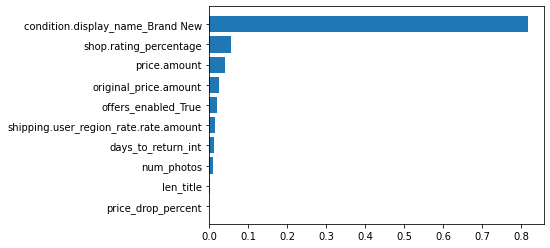

In [1197]:
sorted_idx = xgb2.feature_importances_.argsort()
plt.barh(X_train.iloc[:,included_features_no_leak].columns[sorted_idx], xgb2.feature_importances_[sorted_idx])

I was originally really surprised by how important the "Brand New" condition was to this model, so I compared this to the Reverb search results. The majority of unsold guitars are under the category "Brand New" (about 70%). It looks like many of these are established guitar retailers posting their inventory to Reverb. In contrast, only about 25% of the sold guitars are "Brand New". It seems clear to me that people are not using Reverb to buy new products, which absolutely aligns with my personal experience. Otherwise, these seem like very reasonable features to predict sales.

Based on the features in this model, my advice to those selling music equipment on Reverb is as follows:
- Mark equipment as "Mint" instead of "Brand New" if appropriate
- Shoppers are of course more likely to buy from a shop with a good rating (On Reverb, users get rated for buying products as well, which is a good way to build up a positive account rating.)
- Price as competitively as possible, Reverb has tools to help determine exact values.
- Enable offers, people are more likely to make an offer/negotiate price than buy equipment outright.
- Include as long a return policy as possible.
- Include a good amount of photos in the posting, this gives shoppers more confidence in what they're buying.